# Selection Functions and Number Counts

Using the depths maps for ELAIS-N1 you can calculate the probability that a source of true flux f will be detected in each healpix

In the field with an associated error calculated in the depth map

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import scipy
from scipy.optimize import curve_fit
import scipy.stats
import pickle
import os
from pymoc.util import catalog
from pymoc import MOC
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
#import utils



In [2]:
DMU_LOC = '../../../'

In [3]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [4]:
def gaus_cdf(val, mean,sig):
    
    return(0.5*(1 + scipy.special.erf((val - mean)/(np.sqrt(2)*sig))))

In [5]:
def gaus_prob(errors, confidence, hist_errors):
    '''
    Returns the probability of a source of a given true flux being detected to a confidence level
    The fluxes used for this are in the range 0,98
    This is done assuming gaussian errors
    
    Parameters
    -----------
    Errors: a list of errors found in the field
    confidence: a integer, the confidence level you are working at eg 2/3/4 sigma
    hist_errors: a list of the number of regions of your field that have an error given in errors
    
    Returns
    ---------
    Prob: the probability that a source of given flux will be detected in the field averaged across
    all the regions in the field
    '''
    
    prob = np.zeros(len(hist_errors))
    cutoff = np.zeros(len(hist_errors))
    true_flux = np.arange(0,len(hist_errors),0.1)
    
    cutoffs = confidence * errors
    #print(errors)
    #print(hist_errors)
    #print(cutoffs)

    for n in range(len(errors)-1):
        prob = prob + (1 - scipy.stats.norm(np.array(true_flux[:(len(cutoffs)-1)]),errors[n]).cdf(cutoffs[n]))*hist_errors[n]
    return(prob/sum(hist_errors))

### Load in the depth map and data for Lockman-SWIRE

In [6]:
depth_elais = Table.read(DMU_LOC + 'dmu1/dmu1_ml_ELAIS-N1/data/depths_elais-n1_20180216.fits')
SERVS_elais = Table.read(DMU_LOC + 'dmu1/dmu1_ml_ELAIS-N1/data_tmp/SERVS.fits')
SWIRE_elais = Table.read(DMU_LOC + 'dmu1/dmu1_ml_ELAIS-N1/data_tmp/SWIRE.fits')

In [7]:
servs_coords = SkyCoord(SERVS_elais['servs_ra'],SERVS_elais['servs_dec'])
servs_elais_moc = catalog.catalog_to_moc(servs_coords,10,11)
elais_servs_area = servs_elais_moc.area

swire_coords = SkyCoord(SWIRE_elais['swire_ra'],SWIRE_elais['swire_dec'])
swire_elais_moc = catalog.catalog_to_moc(swire_coords,10,11)
elais_swire_area = swire_elais_moc.area

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


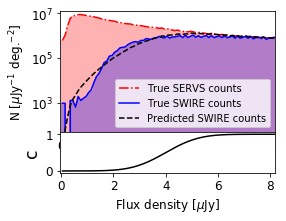

In [12]:
bins = np.arange(0,20,0.1)
bin_cent = get_center(bins)


#fig = plt.figure()
#fig.figsize=[5,3]
#ax1 = fig.add_axes([0.1, 0.6, 1.5, 1.2])
#ax2 = fig.add_axes([0.1, 0.1, 1.5, 0.5])


fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
fig.subplots_adjust(hspace=0, wspace=0)


mask = ~(np.isnan(SERVS_elais['f_servs_irac_i1']))
plotting_servs = np.histogram(SERVS_elais['f_servs_irac_i1'][mask],bins=bins)
ax1.plot(bin_cent,plotting_servs[0]/elais_servs_area,c='red', linestyle='-.', label='True SERVS counts')
weights = np.zeros(len(SERVS_elais[mask]))
weights = weights + 1/elais_servs_area
ax1.hist(SERVS_elais['f_servs_irac_i1'][mask],bins=bins,color='red',alpha=0.3,weights=weights,log=True, label=None)

mask = ~(np.isnan(SWIRE_elais['f_swire_irac_i1']))
plotting_swire = np.histogram(SWIRE_elais['f_swire_irac_i1'][mask],bins=bins)
ax1.plot(bin_cent,plotting_swire[0]/elais_swire_area,c='blue', label='True SWIRE counts')
weights = np.zeros(len(SWIRE_elais[mask]))
weights = weights + 1/elais_swire_area
ax1.hist(SWIRE_elais['f_swire_irac_i1'][mask],bins=bins,color='blue',alpha=0.3,weights=weights,log=True, label=None)

errors = np.arange(0.5,20.5,0.1)
mask = ~np.isnan(depth_elais['ferr_irac_i1_mean'])
irac_error_elais = depth_elais['ferr_irac_i1_mean'][mask]
irac_error_elais = np.histogram(irac_error_elais,errors)
probg_swire = gaus_prob(errors,5,irac_error_elais[0])
cdf = gaus_cdf(bin_cent,4,1)

probg_swire_interp = np.interp(bin_cent,np.arange(0,19.9,0.1),probg_swire)
#ax1.plot(np.arange(0,19.9,0.1),probg_swire_interp*plotting_servs[0]/elais_servs_area,c='red')
ax1.plot(bin_cent,cdf*plotting_servs[0]/elais_servs_area,c='black', linestyle='--', label='Predicted SWIRE counts')

ax2.plot(bin_cent,cdf,c='black')
#ax2.plot(np.arange(0,19.9,0.1),probg_swire,c='red')
ax2.set_xlim([-0.05,8.2])
ax1.set_xlim([-0.05,8.2])
ax1.set_ylim([10**1.7,10**7.1])
ax2.set_ylabel('c',fontsize='xx-large')
ax2.set_xlabel('Flux density [$\mu$Jy]')
ax1.set_ylabel('N [$\mu$Jy$^{-1}$ deg.$^{-2}$]')#,fontsize='xx-large')

ax1.legend()

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 6.9
width_cm = 1.4 * column_width_cm
hieght_cm = width_cm / 1.3 # 1.67
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)


plt.savefig('./figs/completeness.pdf', bbox_inches='tight')
plt.savefig('./figs/completeness.png', bbox_inches='tight')
#plt.show()